# Анализ распределения решающей статистики

Цель: несколькими экспериментами проверить гипотезу о том, что при отсутствии разладки ($H_0$) статистика $2n \cdot D_n(\hat{p} || p)$ сходится по распределению к $\chi^2_{k-1}$, где $k=5$ (число символов алфавита).

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2, probplot, norm, laplace as sp_laplace

np.random.seed()

# Константы кодирования для автономности ноутбука
SYMBOLS = np.array([-2, -1, 0, 1, 2])
SYMBOL_TO_IDX = {s: i for i, s in enumerate(SYMBOLS)}

def encode_slope(diffs, delta=0.2, gamma=1.0):
    diffs = np.asarray(diffs)
    out = np.zeros(len(diffs), dtype=int)
    out[diffs <= -gamma] = -2
    out[(diffs > -gamma) & (diffs <= -delta)] = -1
    out[(diffs > -delta) & (diffs <= delta)] = 0
    out[(diffs > delta) & (diffs <= gamma)] = 1
    out[diffs > gamma] = 2
    return out

def empirical_probs(symbols, laplace=1e-5):
    """
    Добавляем малое сглаживание для предотвращения log(0)
    """
    counts = np.zeros(len(SYMBOLS), dtype=float)
    for s in symbols:
        counts[SYMBOL_TO_IDX[s]] += 1
    counts += laplace
    return counts / counts.sum()

def kl_divergence(p, q):
    return np.sum(p * (np.log(p) - np.log(q)))

In [34]:
def generate_statistic_samples(generator_func, n_train=50000, n_test=500, trials=2000, **kwargs):
    """
    Генерирует выборку значений статистики T = 2 * n * D_n при H0.
    """
    # 1. Оценка истинного распределения (p) на большой выборке
    x_train = generator_func(n_train, **kwargs)
    diffs_train = np.diff(x_train)
    S_train = encode_slope(diffs_train)
    p_true = empirical_probs(S_train)

    T_values = []

    # 2. Многократная генерация тестовых выборок и расчет статистики
    for _ in range(trials):
        x_test = generator_func(n_test, **kwargs)
        diffs_test = np.diff(x_test)
        S_test = encode_slope(diffs_test)
        
        p_hat = empirical_probs(S_test)
        
        # KL и масштабирование
        D = kl_divergence(p_hat, p_true)
        T_stat = 2 * (n_test - 1) * D
        T_values.append(T_stat)

    return np.array(T_values)

# Генераторы различных распределений
def gen_normal(n, sigma=1.0):
    return np.random.normal(0, sigma, n)

def gen_laplace(n, scale=1.0):
    return np.random.laplace(0, scale, n)

def gen_uniform(n):
    return np.random.uniform(-1, 1, n)

def gen_student(n, df=3):
    return np.random.standard_t(df, n)

In [35]:
def visualize_goodness_of_fit(data, df_chi2=4, title="Distribution"):
    """
    Строит гистограмму и QQ-plot для сравнения с хи-квадрат распределением.
    """
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    
    # Гистограмма
    x = np.linspace(0, np.max(data), 200)
    ax[0].hist(data, bins=50, density=True, alpha=0.6, color='skyblue', label='Empirical T')
    ax[0].plot(x, chi2.pdf(x, df=df_chi2), 'r-', lw=2, label=f'Chi2(df={df_chi2})')
    ax[0].set_title(f'Histogram: {title}')
    ax[0].legend()
    
    # QQ-plot
    probplot(data, dist=chi2(df=df_chi2), plot=ax[1])
    ax[1].set_title(f'QQ-Plot: {title}')
    
    plt.tight_layout()
    plt.show()

## Проверка гипотезы для Нормального распределения

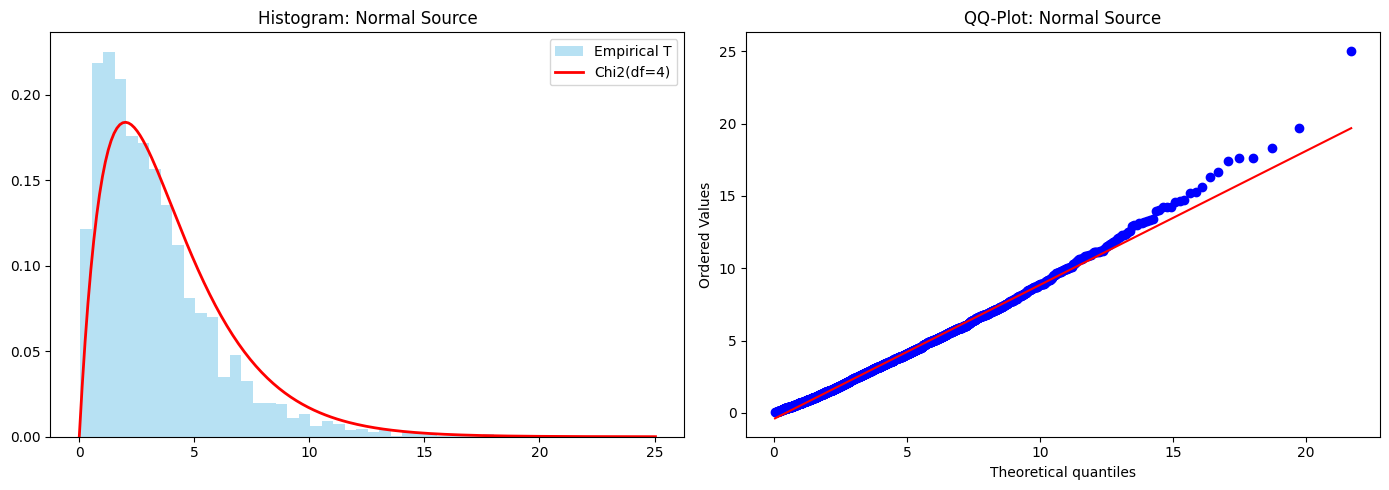

In [36]:
T_normal = generate_statistic_samples(gen_normal, n_test=1000, trials=3000)
visualize_goodness_of_fit(T_normal, df_chi2=4, title="Normal Source")

## Проверка гипотезы для распределения Лапласа

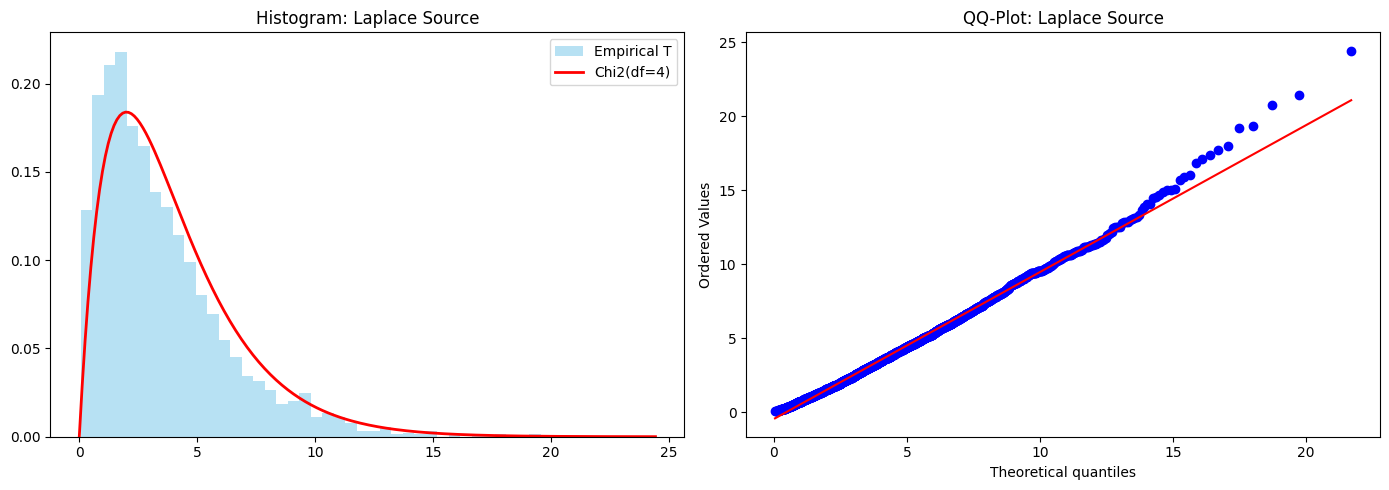

In [37]:
T_laplace = generate_statistic_samples(gen_laplace, n_test=1000, trials=3000)
visualize_goodness_of_fit(T_laplace, df_chi2=4, title="Laplace Source")

## Проверка гипотезы для Равномерного распределения

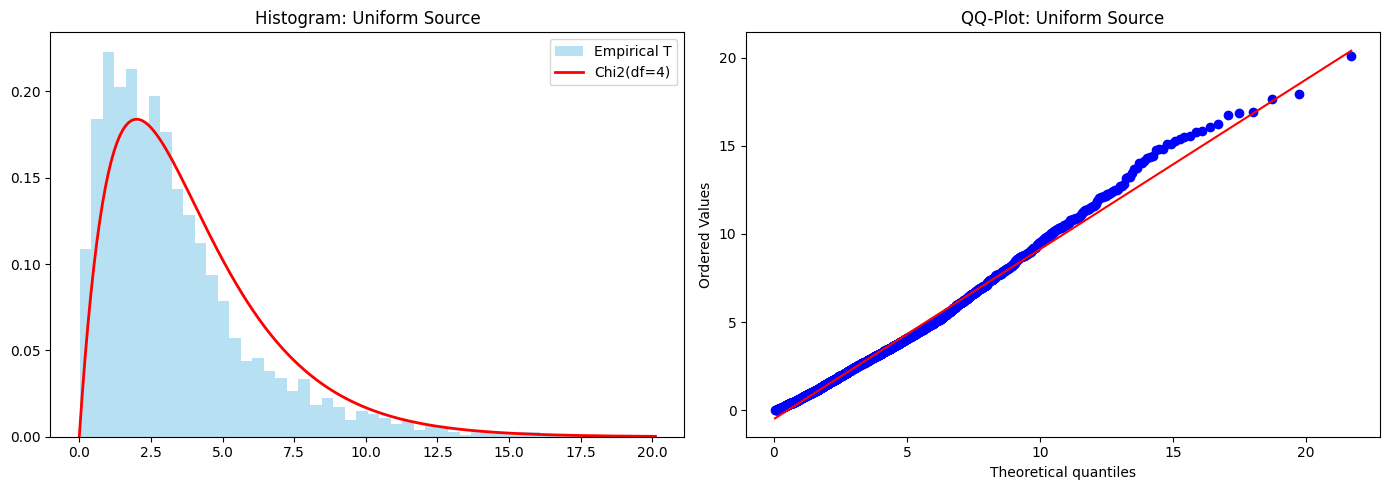

In [38]:
T_uniform = generate_statistic_samples(gen_uniform, n_test=1000, trials=3000)
visualize_goodness_of_fit(T_uniform, df_chi2=4, title="Uniform Source")

## Проверка гипотезы для распределения Стьюдента

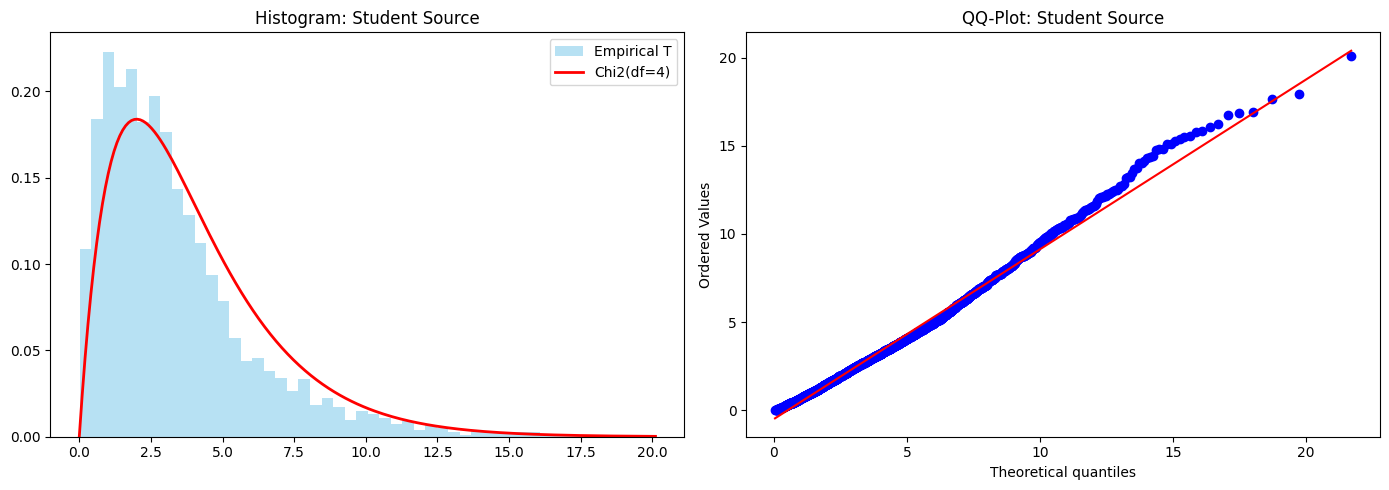

In [39]:
T_student = generate_statistic_samples(gen_student, n_test=1000, trials=3000)
visualize_goodness_of_fit(T_uniform, df_chi2=4, title="Student Source")

## Анализ поведения при $H_1$ (Разладка)

При наличии разладки статистика $2nD_n$ должна отклоняться от $\chi^2$ и расти линейно с ростом $n$.

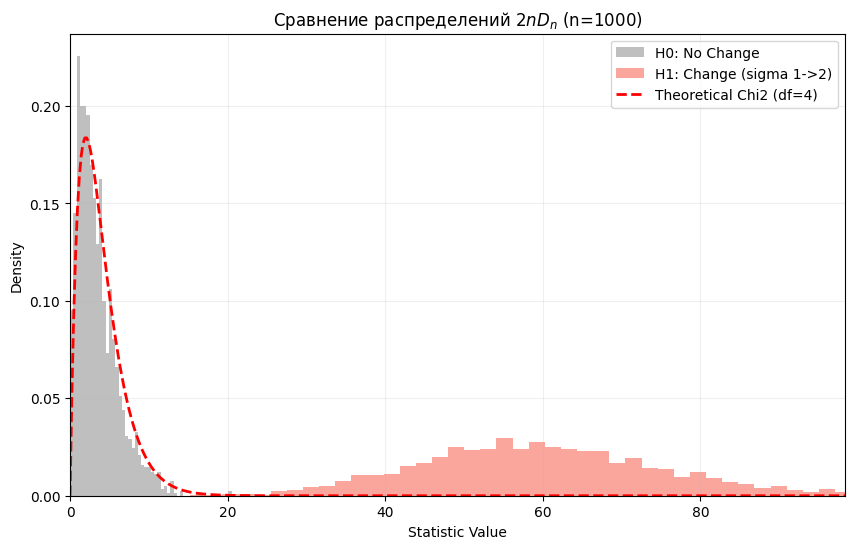

In [40]:
def generate_h1_samples(n_test, trials=1000, sigma0=1.0, sigma1=2.0):
    """
    Генерирует выборку значений 2nD_n в условиях разладки.
    """

    x_ref = np.random.normal(0, sigma0, 50000)
    p_ref = empirical_probs(encode_slope(np.diff(x_ref)))
    
    T_h1 = []
    for _ in range(trials):
        # Разладка в середине выборки
        n1 = n_test // 2
        n2 = n_test - n1
        x = np.concatenate([
            np.random.normal(0, sigma0, n1),
            np.random.normal(0, sigma1, n2)
        ])
        
        p_hat = empirical_probs(encode_slope(np.diff(x)))
        D = kl_divergence(p_hat, p_ref)
        T_h1.append(2 * (n_test - 1) * D)
        
    return np.array(T_h1)

# Параметры теста
N_VAL = 1000
T_h0 = generate_statistic_samples(gen_normal, n_test=N_VAL, trials=2000, sigma=1.0)
T_h1 = generate_h1_samples(n_test=N_VAL, trials=2000, sigma0=1.0, sigma1=2.0)

plt.figure(figsize=(10, 6))
plt.hist(T_h0, bins=50, density=True, alpha=0.5, label='H0: No Change', color='gray')
plt.hist(T_h1, bins=50, density=True, alpha=0.7, label='H1: Change (sigma 1->2)', color='salmon')

x_axis = np.linspace(0, max(T_h1), 500)
plt.plot(x_axis, chi2.pdf(x_axis, df=4), 'r--', lw=2, label='Theoretical Chi2 (df=4)')

plt.title(f'Сравнение распределений $2nD_n$ (n={N_VAL})')
plt.xlabel('Statistic Value')
plt.ylabel('Density')
plt.legend()
plt.xlim(0, np.percentile(T_h1, 99))
plt.grid(True, alpha=0.2)
plt.show()

### Динамика распределения при росте $n$

На QQ-plot для случая $H_1$ также можно увидеть, насколько сильно распределение отклоняется от теоретического $\chi^2$.

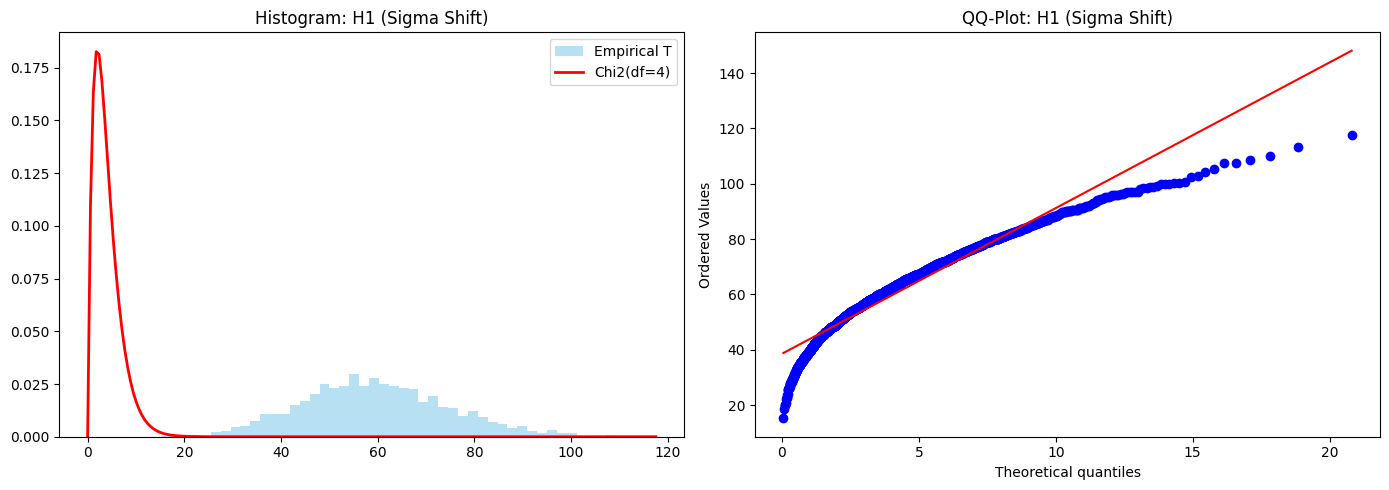

In [42]:
visualize_goodness_of_fit(T_h1, df_chi2=4, title="H1 (Sigma Shift)")